## Strategy

> To trade support and resistance levels as well as some well known chart patterns

### *Signals*

> Bounce on resistance / pass support for 2 days = sell

> Bounce on support / pass resistance for 2 days = buy

> Head and shoulders trade


In [32]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime
from scipy.signal import argrelextrema


In [56]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df = df.iloc[1000:1400]
df.head()


,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Series 8,Series 9,Series 10,...,Series 20,Series 21,Series 22,Series 23,Series 24,Series 25,Series 26,Series 27,Series 28,Series 29
Day,,,,,,,,,,,,,,,,,,,,,
1000,253.081961,267.916355,143.452642,305.223423,223.938297,172.933678,98.828521,296.055412,132.143009,133.493034,...,55.904211,117.248269,93.756331,99.253434,106.567229,170.531792,156.041095,147.762463,64.520958,68.311688
1001,252.457612,268.028379,142.715145,303.069172,224.068247,173.848726,98.095646,294.709848,132.170614,134.280779,...,55.540875,116.981553,93.482967,99.728352,106.449416,170.673448,155.603315,147.564995,66.217565,69.870130
1002,251.741446,266.004481,143.423128,302.879311,224.556542,172.018629,99.046633,293.825741,133.380286,134.834070,...,57.291495,117.530151,93.748699,99.947784,106.625594,170.330789,156.267046,148.780608,63.223553,69.350649
1003,247.667870,256.579537,142.626603,299.267465,218.535901,168.355451,96.696395,291.018664,132.335537,132.131045,...,58.711808,116.613145,93.097898,100.053459,106.007350,167.098275,154.207010,147.335969,69.411178,68.311688
1004,251.566995,261.620612,147.316864,305.223423,223.189744,171.408100,98.834610,290.211232,132.500460,132.365217,...,58.348472,114.920074,92.749601,99.530677,107.122784,169.779763,156.277637,148.921387,64.371257,71.948052


In [57]:
# Identifying turning points

def get_max_min(prices, smoothing, window_range):
    
    smooth_prices = prices.rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range].idxmin())  
            
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['Day'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')
    
    return max_min, maxima, minima

smoothing = 3
window = 10

[minmax, maxima, minima] = get_max_min(df['Series 6'], smoothing, window)
minmax.head()

,date,Series 6
day_num,,
7,1007,173.950232
8,1008,173.848726
13,1013,173.848726
19,1019,173.747220
21,1021,168.456957


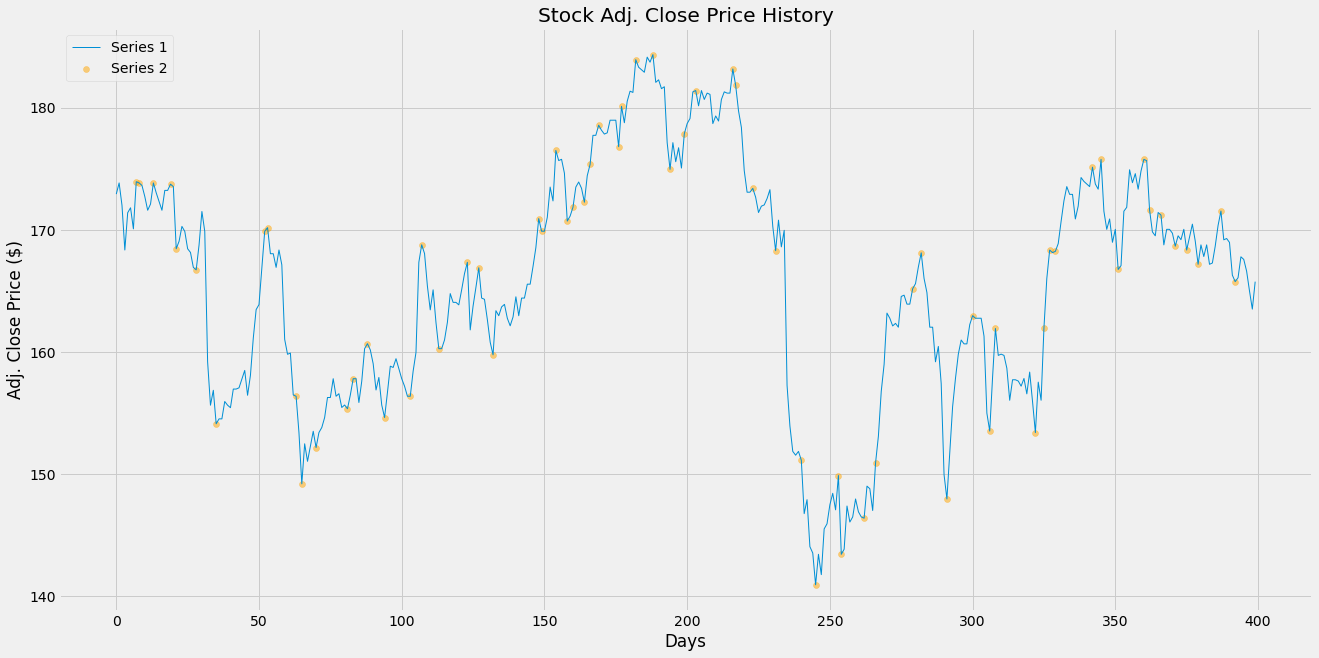

In [58]:
# plotting turning points
#Visualise the data

plt.figure(figsize=(20, 10))
plt.plot(df.reset_index()['Series 6'], linewidth = 1)
plt.scatter(minmax.index, minmax['Series 6'].values, color='orange', alpha=.5)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()


## Strategy 2

#### Identifying levels of support and resistance

In [59]:
# import necessary libraries
import matplotlib.dates as mpl_dates

start = 0
end = 720

# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')

# df selected for testing purposes
data = df['Series 22'].iloc[0:]


In [60]:
#method 1: fractal candlestick pattern
# determine bullish fractal 

def is_support(df,i):  
    
    cond1 = df[i] < df[i-1]   
    cond2 = df[i] < df[i+1]   
    # cond3 = df[i+1] < df[i+2]   
    # cond4 = df[i-1] < df[i-2]  
    return (cond1 and cond2) # and cond3 and cond4) 

# determine bearish fractal
def is_resistance(df,i):  
    
    cond1 = df[i] > df[i-1]   
    cond2 = df[i] > df[i+1]   
    #cond3 = df[i+1] > df[i+2]   
    #cond4 = df[i-1] > df[i-2]  
    return (cond1 and cond2) # and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df): 
    
    ave =  np.mean(abs(df.iloc[2::] - df.iloc[0:-2]))    
    return np.sum([abs(value-level)<ave for _,level in levels])==0

# a list to store resistance and support levels
def leveler(series, start_day, end_day):
    
    levels = []
    lows = []
    highs = []

    data = df[series][start_day:end_day]

    for i in range(data.index[0]+2, data.shape[0] + data.index[0] - 2):  

        if is_support(data, i):    
            low = data[i]    
            if is_far_from_level(low, levels, data):      
                levels.append((i, low)) 
                lows.append((i, low))
        elif is_resistance(data, i):    
            high = data[i]    
            if is_far_from_level(high, levels, data):      
                levels.append((i, high))
                highs.append((i, high))
                
    return levels, lows, highs


In [61]:
# for visualization
def plot_all(levels, df):    
    fig, ax = plt.subplots(figsize=(20, 10))   
    ax.plot(df, linewidth=2, alpha=0.8, label=series)        
    
    for level in levels:        
        plt.hlines(level[1], xmin = df.reset_index()['Day'][level[0]-start], xmax = 
            max(df.reset_index()['Day']), colors='red', linestyle='--', linewidth=1)    
    
    ax.legend()
    ax.set_xlabel('Days')
    ax.set_ylabel('Adj. Close Price ($)')
    ax.set_title('Adj. Close Price vs Important Levels')
        
    plt.show()


In [62]:
#method 2: window shifting method
#using the same symbol as the first example above

# window used to calculate supports and resistance
window = 5

def levelerv2(series, window, start, end):
    
    pivots = []
    max_list = []
    min_list = []
    
    data = df[series][start:end] 
    
    for i in range(window, len(data)-window):

        # taking a window of 9 candles
        high_range = data[i-window:i+window-1]
        current_max = high_range.max()

        # if we find a new maximum value, empty the max_list 
        if current_max not in max_list:
            max_list = []
        max_list.append(current_max)

        # if the maximum value remains the same after shifting 5 times
        if len(max_list)==window and is_far_from_level(current_max,pivots,data):
            pivots.append((high_range.idxmax(), current_max))

        low_range = data[i-window:i+window]
        current_min = low_range.min()

        if current_min not in min_list:
            min_list = []
        min_list.append(current_min)

        if len(min_list)==window and is_far_from_level(current_min,pivots,data):
            pivots.append((low_range.idxmin(), current_min))
    
    return pivots


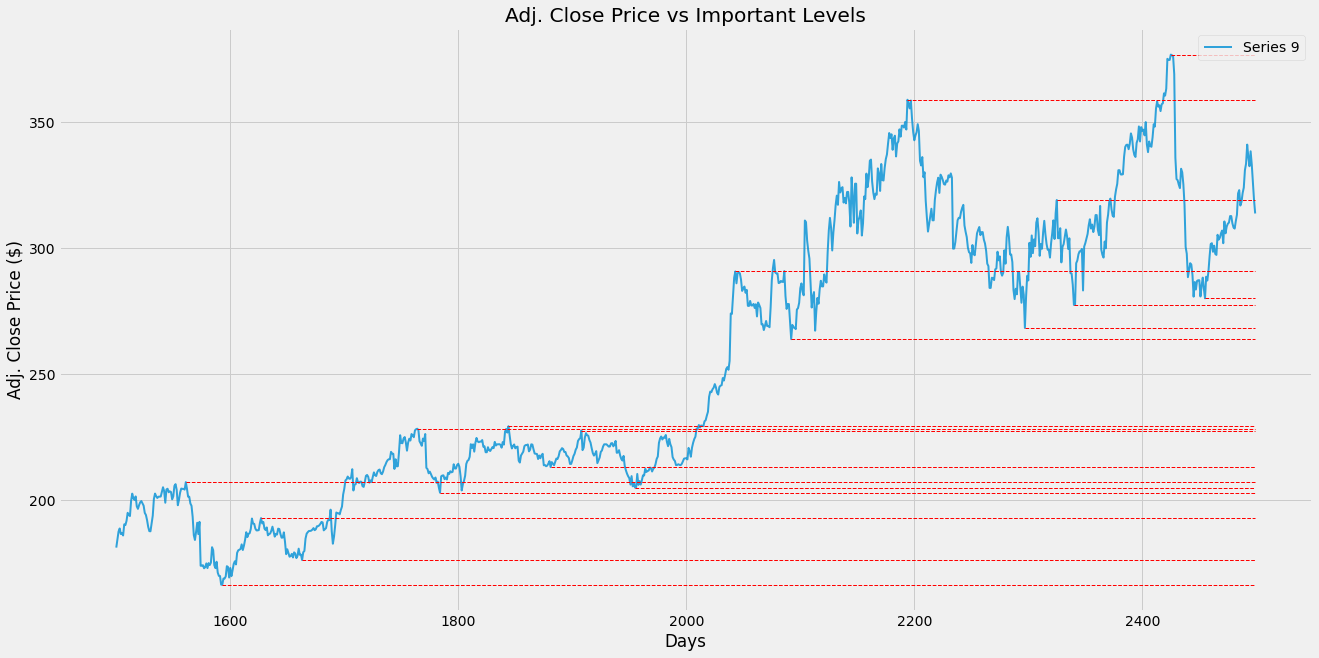

In [63]:
# call function

series = 'Series 9'
start = 1500
end = 2500

plot_all(levelerv2(series, 30, start, end), df[series][start:end])

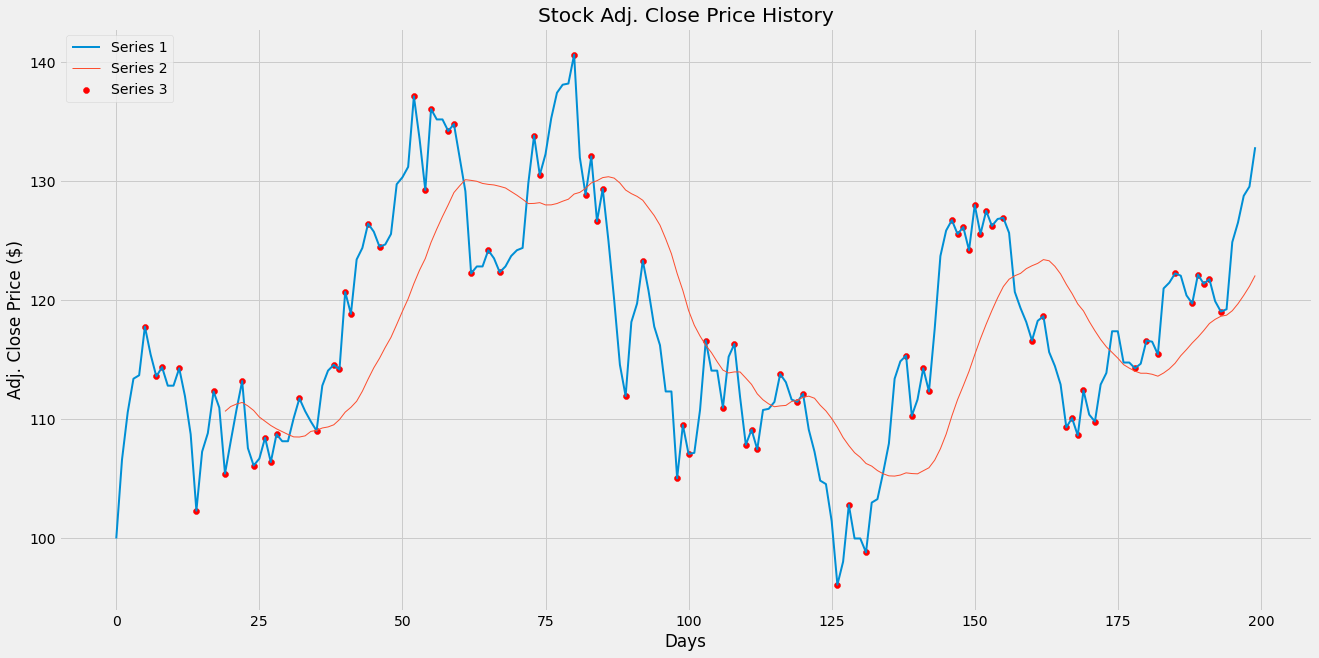

In [64]:
# plotting turning points
#Visualise the data
start_day = 0
end_day = 200
series = 'Series 6'

data = df[series][start_day:end_day]

pivot = pd.DataFrame(leveler(series, start_day, end_day)[0])

plt.figure(figsize=(20, 10))
plt.plot(data, linewidth = 2)
plt.plot(data.rolling(window=20).mean(), linewidth=1)
plt.scatter(pivot[0], pivot[1], color='red', alpha=1)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()

### Strategy

> Fit curve to peaks and troughs

> Look ahead 3 days to t

In [65]:
# imports 
from numpy import arange
from scipy.optimize import curve_fit
 



#### Fitting Sin Curve

In [66]:
# define the true objective function
def objectives(x, a, b, c, d):
    return a * np.sin(b - x) + c * x**2 + d

def fit_sin_curve(series, vision, window, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(levelerv2(series, window, span[0], span[1]))
    else: 
        data1 = df[series][span[0]:span[1]+1].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objectives, x, y)
    # summarize the parameter values
    a, b, c, d = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objectives(x_line, a, b, c, d)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objectives(x_line_f, a, b, c, d)

    return x_line, y_line, x_line_f, y_line_f




#### Fitting 5th Degree Polynomial

In [67]:
# fit a 5th degree polynomial to the economic data
# define the true objective function
def objective5(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

def fit_pent_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]+1].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective5, x, y)
    # summarize the parameter values
    a, b, c, d, e, f = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective5(x_line, a, b, c, d, e, f)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective5(x_line_f, a, b, c, d, e, f)

    return x_line, y_line, x_line_f, y_line_f


#### Fitting 4th Degree Polynomial

In [68]:
# define the true objective function
def objective4(x, a, b, c, d, e):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

def fit_quad_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]+1].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective4, x, y)
    # summarize the parameter values
    a, b, c, d, e = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective4(x_line, a, b, c, d, e)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective4(x_line_f, a, b, c, d, e)

    return x_line, y_line, x_line_f, y_line_f


#### Fitting 3rd Degree Polynomial

In [69]:
# define the true objective function
def objective3(x, a, b, c, d):
    return (a * x) + (b * x**2) + (c * x**3) + d

def fit_tri_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]+1].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective3, x, y)
    # summarize the parameter values
    a, b, c, d = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective3(x_line, a, b, c, d)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective3(x_line_f, a, b, c, d)

    return x_line, y_line, x_line_f, y_line_f


#### Fitting 2nd Degree Polynomial

In [70]:
# define the true objective function
def objective2(x, a, b, c):
    return (a * x) + (b * x**2) + c

def fit_bi_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]+1].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective2, x, y)
    # summarize the parameter values
    a, b, c = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective2(x_line, a, b, c)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective2(x_line_f, a, b, c)

    return x_line, y_line, x_line_f, y_line_f


In [71]:
# define the true objective function
def objective1(x, a, b):
    return (a * x) + b

def fit_lin_curve(series, vision, span, option):
    
    # series is the stock analysed - string
    # vision is how far ahead a predicition is made - integer
    # span is how many data points are used for the estimate - [start, end]
    # option - 0 for turing points, 1 for acutal prices
    
    if option == 0:
        data1 = pd.DataFrame(leveler(series, span[0], span[1])[0])
    else: 
        data1 = df[series][span[0]:span[1]+1].reset_index()

    # choose the input and output variables
    x, y = data1.iloc[:,0], data1.iloc[:,1]

    # curve fit
    popt, _ = curve_fit(objective1, x, y)
    # summarize the parameter values
    a, b = popt

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x)+1, 1)
    # calculate the output for the range
    y_line = objective1(x_line, a, b)

    # plotting predictions
    # define a sequence of inputs between the smallest and largest known inputs
    x_line_f = arange(max(x), max(x)+vision, 1)
    # calculate the output for the range
    y_line_f = objective1(x_line_f, a, b)

    return x_line, y_line, x_line_f, y_line_f


## Plotting / Testing Fits

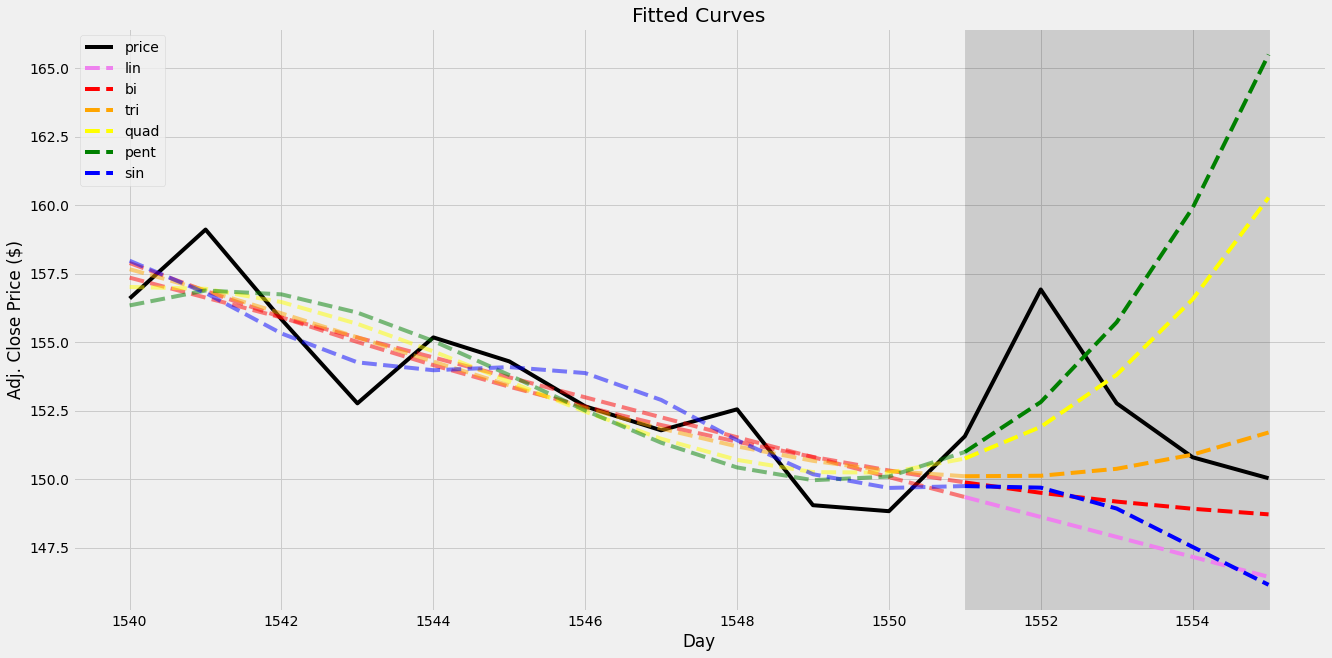

In [72]:
# calling different fitted curves
# calling function

series = 'Series 6'    # series used 
vision = 5          # how far ahead to predict
span1 = [1540,1551]   # window to predict over
window = 5            # used in sin fit for levelerv2 function (higher = more substantial peaks)
option = 1             # 0 = fits for data points, 1 = fits for turning points

# get data
[x_line0, y_line0, x_line_f, y_line_f0] = fit_lin_curve(series, vision, span1, option)
[x_line1, y_line1, x_line_f, y_line_f1] = fit_bi_curve(series, vision, span1, option)
[x_line2, y_line2, x_line_f, y_line_f2] = fit_tri_curve(series, vision, span1, option)
[x_line3, y_line3, x_line_f, y_line_f3] = fit_quad_curve(series, vision, span1, option)
[x_line4, y_line4, x_line_f, y_line_f4] = fit_pent_curve(series, vision, span1, option)
[x_line5, y_line5, x_line_f, y_line_f5] = fit_sin_curve(series, vision, window, span1, option)

# create a line plot for the mapping function
plt.figure(figsize=(20, 10))
plt.plot(df[series][span1[0]:span1[1]+vision], color='black', label='price')

# plot fitted curve
plt.plot(x_line1, y_line0, '--', color='red', alpha=.5)
plt.plot(x_line1, y_line1, '--', color='red', alpha=.5)
plt.plot(x_line2, y_line2, '--', color='orange', alpha=.5)
plt.plot(x_line3, y_line3, '--', color='yellow', alpha=.5)
plt.plot(x_line4, y_line4, '--', color='green', alpha=.5)
plt.plot(x_line5, y_line5, '--', color='blue', alpha=.5)
# plot prediction
plt.plot(x_line_f, y_line_f0, '--', label='lin', color='violet')
plt.plot(x_line_f, y_line_f1, '--', label='bi', color='red')
plt.plot(x_line_f, y_line_f2, '--', label='tri', color='orange')
plt.plot(x_line_f, y_line_f3, '--', label='quad', color='yellow')
plt.plot(x_line_f, y_line_f4, '--', label='pent', color='green')
plt.plot(x_line_f, y_line_f5, '--', label='sin', color='blue')
# separator
plt.axvspan(x_line_f[0], x_line_f[-1], alpha=0.15, color='black')
plt.xlabel('Day')
plt.ylabel('Adj. Close Price ($)')
plt.title('Fitted Curves')

plt.legend()
plt.show()

/Users/oscarwooding/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,ystart,ypstart,ypend,price,gradient
xstart,,,,,
909,153.442837,153.031167,152.619497,155.559702,-0.041167
910,151.459124,155.397021,159.334917,158.274992,0.39379
911,148.533629,159.38833,170.243031,162.699467,1.08547
912,146.860515,163.293685,179.726856,165.213238,1.643317
913,147.807806,165.584441,183.361076,165.213238,1.777663
...,...,...,...,...,...
1195,185.349457,176.492283,167.63511,177.149169,-0.885717
1196,184.831097,175.29698,165.762864,175.587766,-0.953412
1197,183.844234,174.881863,165.919493,176.732695,-0.896237


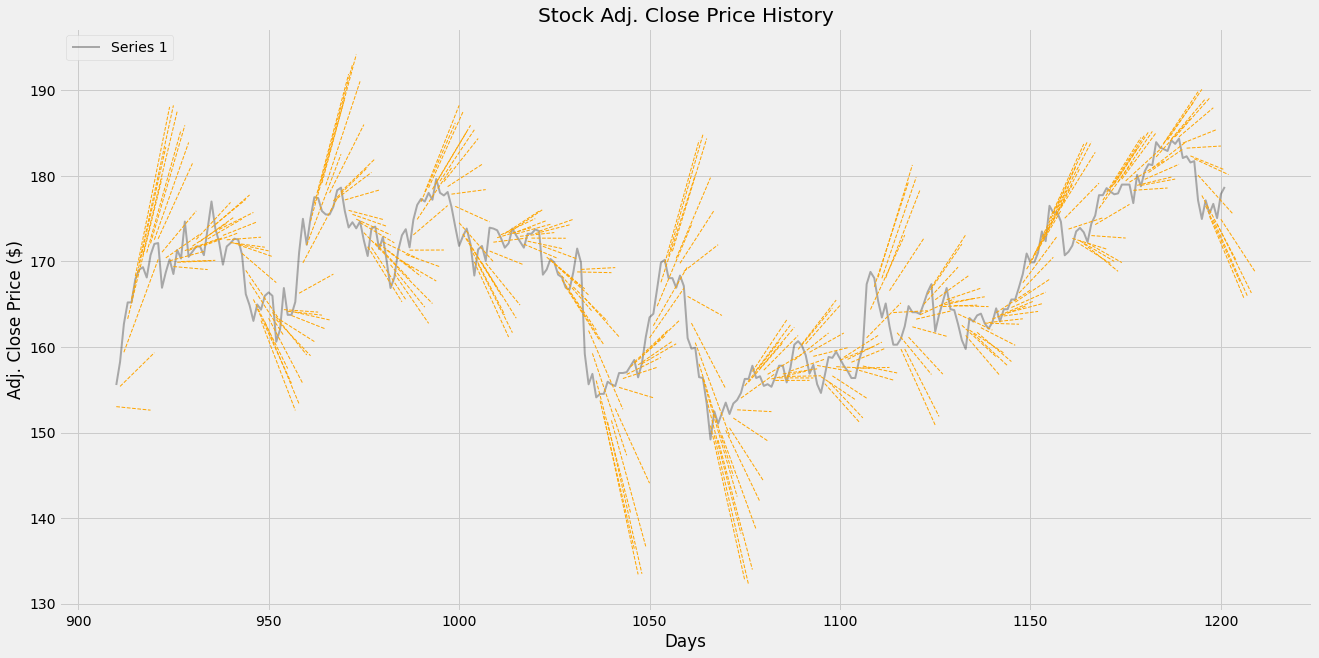

In [73]:
# testing across whole series
def crystal_ball(series, vision, window, sinwindow, start, end, option, predictor, chart):
    
    # series - data used
    # vision - how far ahead to predict
    # window - number of values used in curve fitting
    # sinwindow - number of values used in sin curve fitting for levels
    # start - observation period start
    # end - observation period end
    # option - used in predictor (0 uses turning point data, 1 uses price data)
    # predictor - type of interpolation (5 uses 5th deg poly, 4 - 4th, 3 - 3rd, 2 - 2nd, 1 - sin)
    # chart - 1 = graph, 0 = no graph
    
    data1 = df[series][start+window-1:end]
    
    if chart == 1:
        # plot initial curve
        plt.figure(figsize=(20, 10))
        plt.plot(data1.index+1, data1.values, linewidth = 2, color='black', alpha=.3, label=series)
        plt.title('Stock Adj. Close Price History')
        plt.xlabel('Days')
        plt.ylabel('Adj. Close Price ($)')
        plt.legend(df, loc='upper left')
    
    # storing predictions
    predictions = pd.DataFrame(columns=['xstart', 'ystart', 'ypstart', 'ypend', 'price'])
    
    # plot guess per time step
    for i in range(start, end-window):
        
        span = [i, i+window-1]
        
        if predictor == 5:
            [x_line, y_line, x_line_f, y_line_f] = fit_pent_curve(series, vision, span, option)
        elif predictor == 4:
            [x_line, y_line, x_line_f, y_line_f] = fit_quad_curve(series, vision, span, option)
        elif predictor == 3:
            [x_line, y_line, x_line_f, y_line_f] = fit_tri_curve(series, vision, span, option)
        elif predictor == 2:
            [x_line, y_line, x_line_f, y_line_f] = fit_bi_curve(series, vision, span, option)
        elif predictor == 0:
            [x_line, y_line, x_line_f, y_line_f] = fit_lin_curve(series, vision, span, option)
        elif predictor == 1:
            [x_line, y_line, x_line_f, y_line_f] = fit_sin_curve(series, vision, span, option)
        
        if chart == 1: 
            # create a line plot for the mapping function
            plt.plot(x_line_f+1, y_line_f, '--', color='orange', linewidth=1)
        
        # add data points
        predictions = pd.concat([predictions, pd.DataFrame([[x_line[-1], y_line[0], y_line_f[0], y_line_f[-1], data1[i+window-1]]], \
                                             columns=['xstart', 'ystart', 'ypstart', 'ypend', 'price'])])
        
        #if i%100 == 0:
            #print('Finished prediction %.d of %.d' % (i-start, end-window-start))
    
    predictions['gradient'] = (predictions['ypend']-predictions['ypstart'])/window
    predictions = predictions.set_index('xstart', drop=True)
        
    return predictions

# call function
crystal_ball('Series 6', 10, 10, 20, 900, 1201, 1, 0, 1)
        
        

In [74]:
# fitted curve strategy

def curveball(series, vision, window, sinwindow, start, end, option, predictor): 

    # series - data used
    # vision - how far ahead to predict
    # window - number of values used in curve fitting
    # sinwindow - number of values used in sin curve fitting for levels
    # start - observation period start
    # end - observation period end
    # option - used in predictor (0 uses turning point data, 1 uses price data)
    # predictor - type of interpolation (5 uses 5th deg poly, 4 - 4th, 3 - 3rd, 2 - 2nd, 1 - sin)
    
    # generate data
    data = crystal_ball(series, vision, window, sinwindow, start, end, option, predictor, 1).reset_index()

    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
      
    #flag = 1: long position, flag = 0: short position, flag = -1: no position
    flag = -1

    for i in range(len(data)):
        # closing trade at end of session
        if i == len(data)-1:
            if flag == 1:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data['price'][i])
                flag = -1
            elif flag == 0:
                sigPriceBuy.append(data['price'][i])
                sigPriceSell.append(np.nan)
                flag = -1
            else: 
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
                flag = -1
        # Touch of lower bound = close sell and build long position
        elif data['gradient'][i] > 0:
            if flag != 1:
                sigPriceBuy.append(data['price'][i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data['gradient'][i] < 0:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data['price'][i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)

    return (sigPriceBuy, sigPriceSell)


/Users/oscarwooding/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


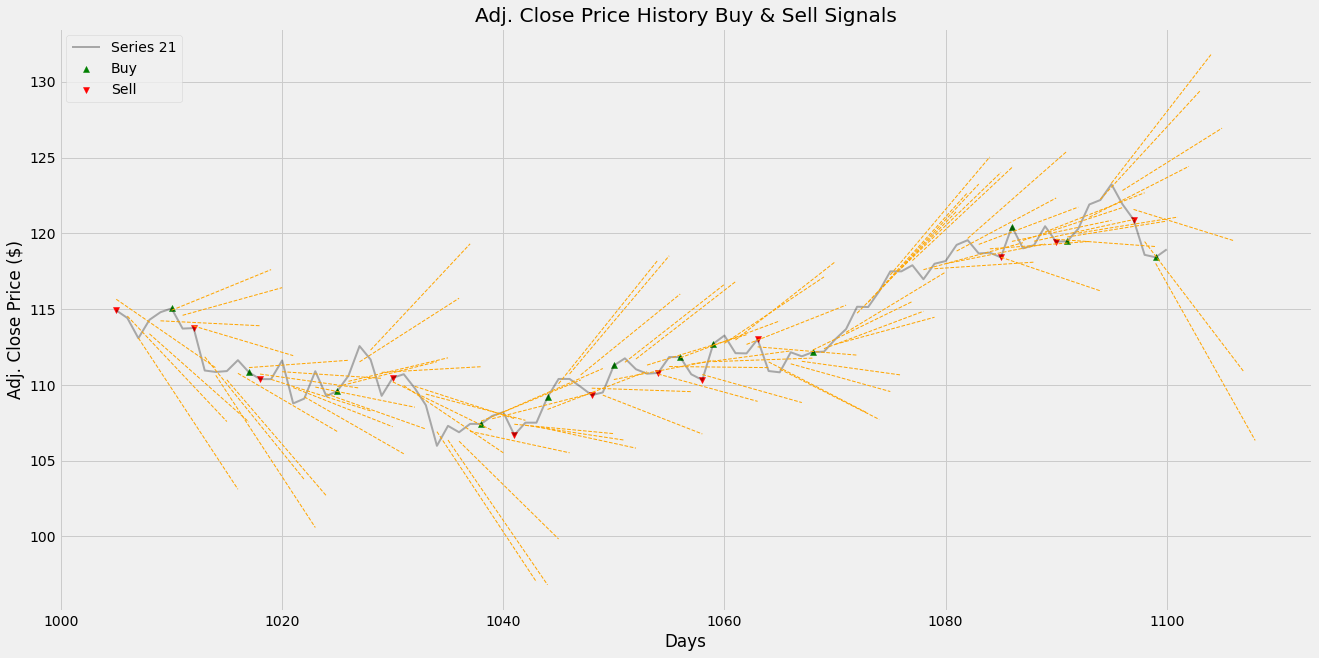

Profit for this strategy assuming long only is 0
Profit for this strategy assuming long only is 3


In [83]:
# Calling function

# inputs
series = 'Series 21'
vision = 10
window = 5
sinwindow = 20
start = 1000 
end = 1100 
opiton = 1
predictor = 0

for series in ['Series 21']:
    # call
    buy_sell_data = curveball(series, vision, window, sinwindow, start, end, option, predictor)
    buy_sell_data

    # testing basic strategy
    # To test, change window and the series used

    # adding indicators
    plt.scatter(np.arange(start+window,end), buy_sell_data[0], label='Buy', marker='^', color='green')
    plt.scatter(np.arange(start+window,end), buy_sell_data[1], label='Sell', marker='v', color='red')
    plt.title('Adj. Close Price History Buy & Sell Signals')
    plt.xlabel('Days')
    plt.ylabel('Adj. Close Price ($)')
    plt.legend(loc='upper left')
    plt.show()

    # Calculating profit
    # for closing at sells
    profit = np.nansum(buy_sell_data[1]) - np.nansum(buy_sell_data[0])
    print('Profit for this strategy assuming long only is %.d' % (profit))
    # for retrade sells
    profit = np.nansum(2*buy_sell_data[1][1:-1]) - 2*np.nansum(buy_sell_data[0][1:-1]) \
            + np.nansum([-buy_sell_data[0][0], buy_sell_data[1][0]]) + np.nansum([-buy_sell_data[0][-1], buy_sell_data[1][-1]])
    print('Profit for this strategy assuming long only is %.d' % (profit))

In [76]:
np.nansum([-buy_sell_data[0][0], buy_sell_data[1][0]])
np.nansum([-buy_sell_data[0][-1], buy_sell_data[1][-1]])

49.87012987012986